In [1]:
import numpy as np
import re
import plotly
plotly.tools.set_credentials_file(username='sehowerter', api_key='G5Ogb7gUjjxyuw46SW2r')
plotly.tools.set_config_file(world_readable=False,
                             sharing='private')
import plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import pandas as pd
import glob
import ternary

# Getting all ratios into one dataframe

In [65]:
allratios = pd.DataFrame(columns = ['user','tweet_id','happ_score', 'happ_words', 'likes', 'replies',
       'retweets', 'scrape_date', 'total_words', 'tweet_date','url'])
allratiofiles = glob.glob('ratios/*')
print('All of the users we have ratios & tweet reply conversations for:')
for file in allratiofiles:
    sname = re.search('(?<=ratios/).*(?=-ratios.csv)',file).group(0)
    print(sname)
    rdf = pd.read_csv(file)
    rdf = rdf.drop("Unnamed: 0",axis=1)
    rdf = rdf.dropna(axis=0, how='any')
    rdf['user'] = sname
    allratios = pd.concat([allratios,rdf],ignore_index=True)

for tID in list(allratios['tweet_id']):
    subset = allratios.loc[allratios['tweet_id'] == tID]
    if len(subset.index) == 2:
        hapwords = subset['happ_words']
        drop = subset.index[subset['happ_words']== min(hapwords)]
        allratios = allratios.drop(drop, axis=0)
    elif len(subset.index) > 2:
        pass
        print('dulicate tweet! ',list(subset.index))
        
    
for i in allratios.index:
    try:
        allratios.loc[i,'replies'] = float(allratios.loc[i,'replies'])
    except:
        allratios.loc[i,'replies'] = float(allratios.loc[i,'replies'][:-1])*1000
    tot = allratios.loc[i,'replies'] + allratios.loc[i,'retweets'] + allratios.loc[i,'likes']
    allratios.loc[i,'norm_replies'] = allratios.loc[i,'replies']/tot
    allratios.loc[i,'norm_retweets'] = allratios.loc[i,'retweets']/tot
    allratios.loc[i,'norm_likes'] = allratios.loc[i,'likes']/tot
    if allratios.loc[i,'happ_words'] < 200:
        allratios.loc[i,'happ_score'] = np.nan
        #print(allnormratios.loc[i,'tweet_id'],' from {} dropped'.format(allnormratios.loc[i,'user']))
        
# Subsetting to plot
allhapp_ratios = allratios[['retweets','replies','likes','happ_score','user','tweet_id']]
allwords_ratios = allratios[['retweets','replies','likes','happ_words','user']]
allhapp_ratios = allhapp_ratios.T.to_dict().values()
allwords_ratios = allwords_ratios.T.to_dict().values()



All of the users we have ratios & tweet reply conversations for:
BillGates
EPAScottPruitt
SenBennetCO
MileyCyrus
cnnbrk
LilTunechi
InhofePress
JerryMoran
TheTweetOfGod
BarackObama
SenSanders
SenKamalaHarris
POTUS
realDonaldTrump
JackKingston
BillCassidy
SenatorLeahy
chrissyteigen
LindseyGrahamSC
SenSchumer
SenWarren
BillClinton
jimmyfallon
HillaryClinton
TheEllenShow
SenBillNelson
SenCoryGardner
KellyannePolls
kanyewest
McConnellPress
BBCBreaking
SethAbramovitch
Drake
FoxNews
SenatorRounds
SenateMajLdr
SenAngusKing
ladygaga
xychelsea
KatyTurNBC
hughhewitt
lisamurkowski
SenDeanHeller
CillizzaCNN
SenRubioPress
SenJohnMcCain
SenBlumenthal
SenAlexander
taylorswift13
VP
ChrisCoons
katyperry
JohnBoozman
Comey
iamcardib
whca
KingJames
ShaniaTwain
RandPaul
SenTedCruz
SenateGOP
StephenAtHome


## Finding the most and least happy tweet convo

In [66]:
happmin = min(list(allratios['happ_score']))
happmax = max(list(allratios['happ_score']))   
screenname_least = allratios.loc[allratios.happ_score == happmin,'user'].item()
screenname_most = allratios.loc[allratios.happ_score ==happmax,'user'].item()
tweetid_least = allratios.loc[allratios.happ_score == happmin,'tweet_id'].item()
tweetid_most = allratios.loc[allratios.happ_score ==happmax,'tweet_id'].item()

print('least happy reply thread got a score of ',happmin,' from ',screenname_least,' @ ',str(allratios.loc[allratios.happ_score == happmin,'url'].item()))
print(' w/ a ratio of: R=',str(allratios.loc[allratios.happ_score == happmin,'replies'].item()),'; RT=',str(allratios.loc[allratios.happ_score == happmin,'retweets'].item()),'; L=',str(allratios.loc[allratios.happ_score == happmin,'likes'].item()),)
print('most happy reply thread got a score of ',happmax,' from ',screenname_most,' @ ',str(allratios.loc[allratios.happ_score == happmax,'url'].item()))
print(' w/ a ratio of: R=',str(allratios.loc[allratios.happ_score == happmax,'replies'].item()),'; RT=',str(allratios.loc[allratios.happ_score == happmax,'retweets'].item()),'; L=',str(allratios.loc[allratios.happ_score == happmax,'likes'].item()),)


least happy reply thread got a score of  4.80108474577  from  SenRubioPress  @  http://twitter.com/SenRubioPress/status/887089048170500100
 w/ a ratio of: R= 391.0 ; RT= 2000 ; L= 1857
most happy reply thread got a score of  7.25051671733  from  SenKamalaHarris  @  http://twitter.com/SenKamalaHarris/status/921127101578797058
 w/ a ratio of: R= 115.0 ; RT= 138 ; L= 1395


# Plotting all tweet ratios with happiness

In [68]:
rawData = list(allhapp_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['user'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'cmin':happmax,
        'cmax':happmin,
        'size': 4,
        'colorbar':{'title':'Happiness Score'
                   },
        'colorscale':'YlOrRd',# Viridis Jet YlOrRd
        'showscale':True
    },
    }]
layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of Tweets:',
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)

# Plotting agin to save fig at higher quality
rawData = list(allhapp_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['user'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'cmin':happmax,
        'cmax':happmin,
        'size': 10,
        'colorbar':{'title':'Happiness Score',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 },
                   },
        'colorscale':'YlOrRd',# Viridis Jet YlOrRd
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of All Tweets:',
        'x': .5,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/ALL-ratio-happiness.jpeg')


In [52]:
ls ratios/

BBCBreaking-ratios.csv      SenSanders-ratios.csv
BarackObama-ratios.csv      SenSchumer-ratios.csv
BillCassidy-ratios.csv      SenTedCruz-ratios.csv
BillClinton-ratios.csv      SenWarren-ratios.csv
BillGates-ratios.csv        SenateGOP-ratios.csv
ChrisCoons-ratios.csv       SenateMajLdr-ratios.csv
CillizzaCNN-ratios.csv      SenatorLeahy-ratios.csv
Comey-ratios.csv            SethAbramovitch-ratios.csv
Drake-ratios.csv            ShaniaTwain-ratios.csv
EPAScottPruitt-ratios.csv   StephenAtHome-ratios.csv
FoxNews-ratios.csv          TheEllenShow-ratios.csv
InhofePress-ratios.csv      TheTweetOfGod-ratios.csv
JackKingston-ratios.csv     VP-ratios.csv
JerryMoran-ratios.csv       chrissyteigen-ratios.csv
JohnBoozman-ratios.csv      cnnbrk-ratios.csv
KatyTurNBC-ratios.csv       hughhewitt-ratios.csv
KellyannePolls-ratios.csv   iamcardib-ratios.csv
KingJames-ratios.csv        jimmyfallon-ratios.csv
LilTunechi-ratios.csv       kanyewest-ratios.csv

MileyCyrus-ratios.csv       ladygaga-ratios

# Comparing mulitple user's ratios (average ratio plot)

In [ ]:
### Uncomment to choose particular users
#users = ['realDonaldTrump','LindseyGrahamSC','SenTedCruz','BillCassidy','SenSanders','SenWarren','SenSchumer']

### Use the below to look at everyone's averages
users = set(list(allratios['user']))
usercolors = ['rgb(216, 8, 8)','rgb(183, 121, 7)','rgb(201, 198, 28)','rgb(65, 130, 35)','rgb(0, 135, 69)','rgb(15, 127, 168)','rgb(10, 34, 114)','rgb(107, 62, 163)','rgb(107, 62, 163)']
i = 0
data = [{
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [],
        'b': [],
        'c': [],
        'text': [],
        'legendgroup': 'group', # this can be any string, not just "group"
        'name': [],
        'marker': {
            'color': [],
            'cmin':happmin,
            'cmax':happmax,
            'size': [],
            'colorbar':{'title':'Avg. Happiness Score'
                       },
            'colorscale':'YlOrRd',# Viridis Jet YlOrRd
            'showscale':True,
            #'line':{
                #'color': usercolors[i],
                #'width':1
    #        }
    }}]

for u in users:
    allratios_user = allratios[allratios.user == u]
    totinteraction = sum(list(allratios_user['replies'])) + sum(list(allratios_user['retweets'])) + sum(list(allratios_user['likes']))
    #print(u,' total interactions = ',totinteraction)
    # Subsetting to plot
    allhapp_ratios = allratios_user[['norm_retweets','norm_replies','norm_likes','happ_score']]
    data[0]['a'].append(np.mean(list(allhapp_ratios['norm_retweets'])))
    data[0]['b'].append(np.mean(list(allhapp_ratios['norm_replies'])))
    data[0]['c'].append(np.mean(list(allhapp_ratios['norm_likes'])))
    #data[0]['group'].append(group)
    data[0]['text'].append(u+"'s avg. happiness="+str(np.nanmean(list(allhapp_ratios['happ_score']))))
    data[0]['marker']['color'].append(np.nanmean(list(allhapp_ratios['happ_score'])))
    data[0]['marker']['size'].append(np.log(totinteraction))
    i += 1
  

In [85]:
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

layout = {
    'title':'Colored by Avg. Happiness Score of Reply Conversations',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'h'},
    'annotations': [{
      'showarrow': False,
      'text': 'Average Ratios of Twitter Users:',
        'x': .5,
        'y': 1.17,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)


# Comparing mulitple user's ratios (all tweets plot)

In [62]:
users = ['realDonaldTrump','LindseyGrahamSC','SenTedCruz','BillCassidy','SenSanders','SenWarren','SenSchumer']
usercolors = ['rgb(216, 8, 8)','rgb(183, 121, 7)','rgb(201, 198, 28)','rgb(65, 130, 35)','rgb(0, 135, 69)','rgb(15, 127, 168)','rgb(10, 34, 114)','rgb(107, 62, 163)','rgb(107, 62, 163)']
i = 0
data = []
for u in users:
    allratios_user = allratios[allratios.user == u]
    # Subsetting to plot
    allhapp_ratios = allratios_user[['retweets','replies','likes','happ_score','user']]
    allhapp_ratios = allhapp_ratios.T.to_dict().values()
    rawData = list(allhapp_ratios);
    data.append({
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [i for i in map(lambda x: x['retweets'], rawData)],
        'b': [i for i in map(lambda x: x['replies'], rawData)],
        'c': [i for i in map(lambda x: x['likes'], rawData)],
        'text': [i for i in map(lambda x: str(x['happ_score']), rawData)],
        'legendgroup': 'user', # this can be any string, not just "group"
        'name': u,
        'marker': {
            'color': [i for i in map(lambda x: x['happ_score'], rawData)],
            'cmin':happmin,
            'cmax':happmax,
            'size': 4,
            'colorbar':{'title':'Happiness Score'
                       },
            'colorscale':'Greys',# Viridis Jet YlOrRd
            'showscale':True,
            'line':{
                'color':usercolors[i],
                'width':1
            }}})
    i += 1

    
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'h'},
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of Tweets:',
        'x': .5,
        'y': 1.23,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)


# Plotting the tweets of 1 person

In [6]:
screenname = 'kanyewest'
ratios = pd.read_csv('ratios/{}-ratios.csv'.format(screenname))
ratios = ratios.drop("Unnamed: 0",axis=1)
ratios = ratios.dropna(axis=0, how='any')
ratios['tweet'] = ""
ratios
for i in ratios.tweet_id:
    subset = ratios.loc[ratios['tweet_id']==i]
    if len(subset.index) == 2:
        print(list(subset.index))
        hapwords = subset['happ_words']
        drop = subset.index[subset['happ_words']== min(hapwords)]
        print(drop,'will be dropped')
        ratios = ratios.drop(drop, axis=0)
    elif len(subset.index) > 2:
        print(list(subset.index))
#ratios        

In [7]:
tweetfiles = glob.glob('tweet_convos/{}/*'.format(screenname))
for i in ratios.index:
    file = [f for f in tweetfiles if str(ratios.loc[i,'tweet_id']) in str(f)]
    #print(file)
    for f in file:
        if 'convo-' in f:
            pass
        else:
            tweetstring = open(f,'r',encoding = 'utf-8')
            ratios.loc[i,'tweet'] = tweetstring.read()
#ratios

In [8]:
normratios = ratios
normratios['tup'] = 0
for i in normratios.index:
    try:
        normratios.loc[i,'replies'] = float(normratios.loc[i,'replies'])
    except:
        normratios.loc[i,'replies'] = float(normratios.loc[i,'replies'][:-1])*1000
    tot = normratios.loc[i,'replies'] + normratios.loc[i,'retweets'] + normratios.loc[i,'likes']
    normratios.loc[i,'replies'] = normratios.loc[i,'replies']/tot
    normratios.loc[i,'retweets'] = normratios.loc[i,'retweets']/tot
    normratios.loc[i,'likes'] = normratios.loc[i,'likes']/tot
    if normratios.loc[i,'happ_words'] < 200:
        normratios.loc[i,'happ_score'] = np.nan
        ratios.loc[i,'happ_score'] = np.nan
        #print(normratios.loc[i,'tweet_id'],' from {} has < 200 words in the tweet convo'.format(screenname))
 

    
happ_ratios = ratios[['retweets','replies','likes','happ_score','tweet']]
words_ratios = normratios[['retweets','replies','likes','happ_words','tweet']]
happ_ratios = happ_ratios.T.to_dict().values()
words_ratios = words_ratios.T.to_dict().values()
happ_tups = []
for i in normratios.index:
    happ_tups.append([(normratios.loc[i,'retweets'], normratios.loc[i,'replies'], normratios.loc[i,'likes']), normratios.loc[i,'happ_score']])

#happ_ratios

In [9]:
rawData = list(happ_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'cmax':happmax,
        'cmin':happmin,
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'size': 4,
        'colorbar':{'title':'Happiness Score'
                   },
        'colorscale':'YlOrRd',
        'showscale':True
    },
    }]
layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)

In [286]:
rawData = list(words_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 0 },
      'tickangle': tickangle,
      'tickfont': { 'size': 0 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_words'], rawData)],
        'size': 7,
        'colorbar':{'title':'labMT Word Count'
                   },
        'colorscale':'YlOrRd',
        'showscale':True
    },
    }]
layout = {
    'title': 'Colored by labMT Word Count of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies', 45),
        'caxis': makeAxis('<br>Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-wordcount.jpeg'.format(screenname))
py.offline.iplot(fig)


In [126]:
rawData = list(happ_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'cmax':7.5,
        'cmin':5,
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'size': 13,
        'colorbar':{'title':'Happiness Score',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 },
                   },
        'colorscale':'Viridis',
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .555,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/happplots/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per day. If you need to raise your daily limit, consider upgrading to a Student or Personal Plan (see: https://plot.ly/products/cloud).

In [120]:
rawData = list(words_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_words'], rawData)],
        'size': 13,
        'colorbar':{'title':'labMT Word Count',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 }
                   },
        'colorscale':'Viridis',
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by labMT Word Count of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .555,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/wordcountplots/{}-ratio-wordcount.jpeg'.format(screenname))
py.offline.iplot(fig)

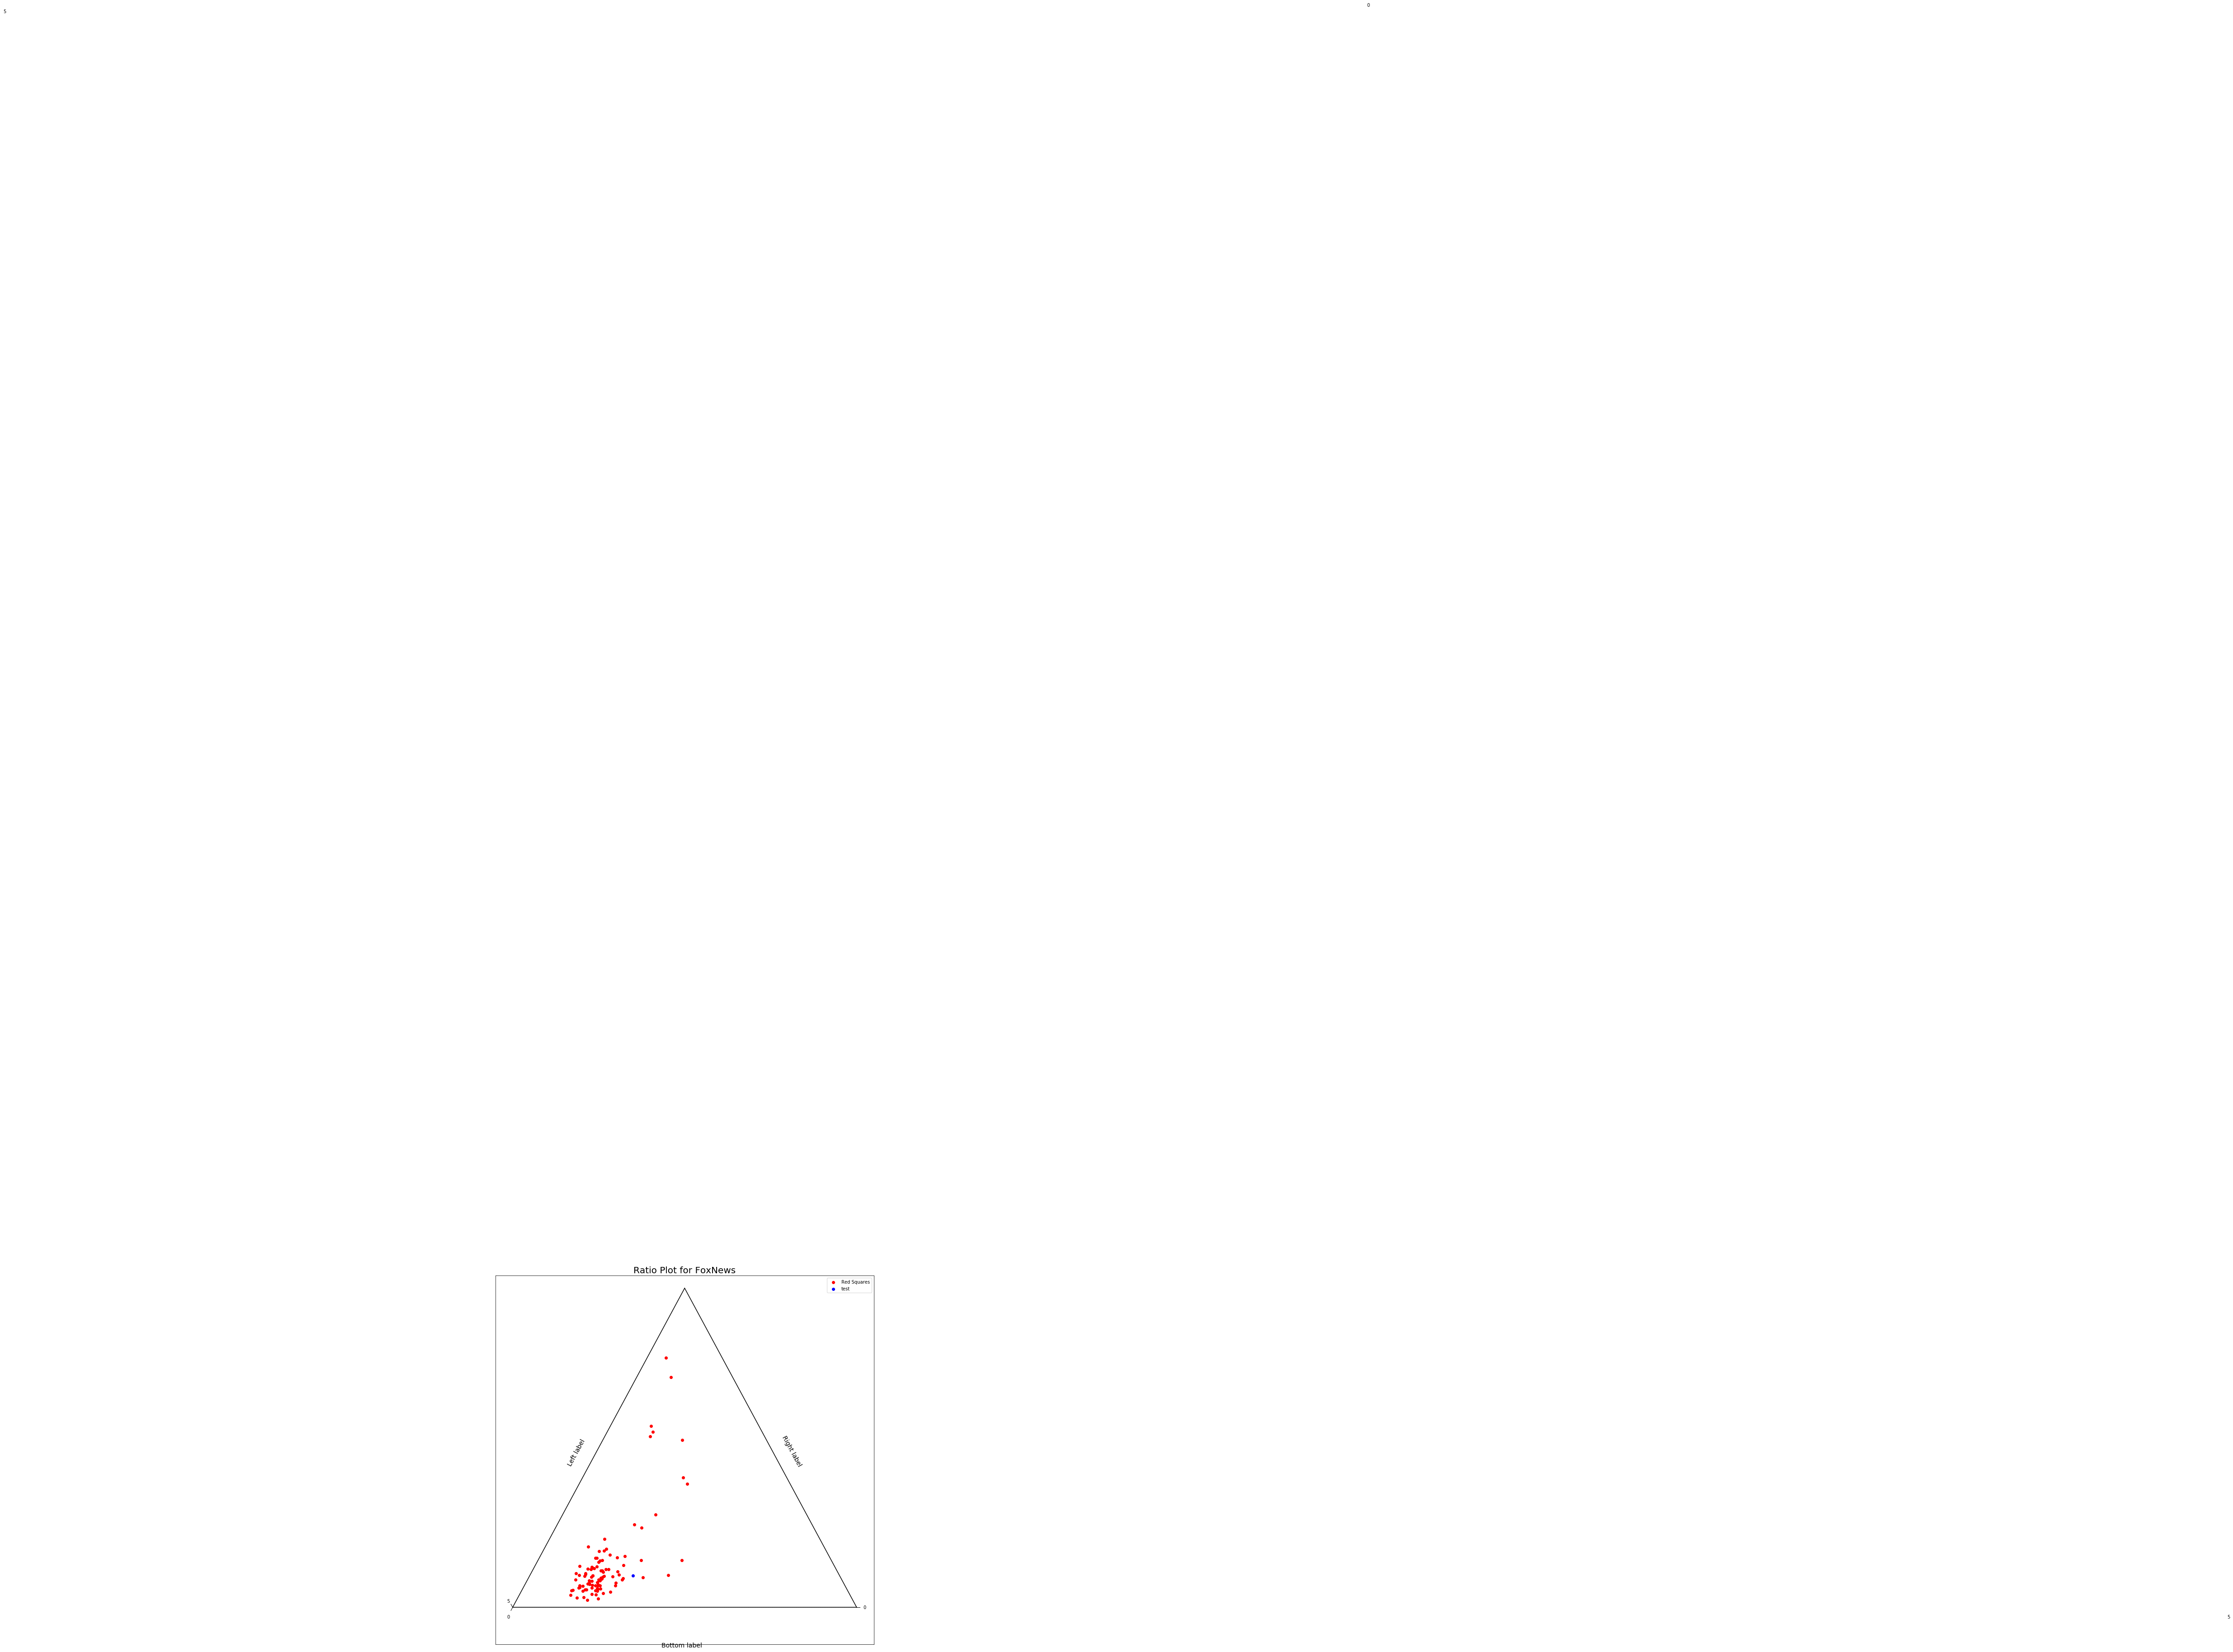

In [349]:
scale = 1

figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(15, 15)
# Set Axis labels and Title
tax.boundary(linewidth=1.5)
tax.gridlines(multiple=5, color="k")
tax.set_title("Ratio Plot for {}".format(screenname), fontsize=20)
tax.left_axis_label("Left label ", fontsize=14)
tax.right_axis_label("Right label ", fontsize=14)
tax.bottom_axis_label("Bottom label ", fontsize=14)

# Plot a few different styles with a legend
points = [i[0] for i in happ_tups]
tax.scatter(points, marker='o', color='red', label="Red Squares")
tax.scatter([(.3,.1,.6)],color='blue',label='test')
tax.legend()
tax.ticks(linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.savefig('taxplot.pdf')
tax.show()

In [23]:
import pickle

In [31]:
file = open('ratiodictTheTweetOfGod.pkl',"rb")
ratiosGod = pickle.load(file)
ratiosGod = pd.DataFrame(ratiosGod).transpose()
ratiosGod
#ratiosGod.to_csv('ratios/{}-ratios.csv'.format('TheTweetOfGod'))



,happ_score,happ_words,likes,replies,retweets,scrape_date,total_words,tweet_date,tweet_id,url
974665705328005121,5.9214,365,11788,150,2730,2018-04-29_17_17_29,1253,2018-03-16,974665705328005121,http://twitter.com/TheTweetOfGod/status/974665...
974713843166269441,6.08265,961,48473,621,10810,2018-04-29_17_16_06,3372,2018-03-16,974713843166269441,http://twitter.com/TheTweetOfGod/status/974713...
974816867553439744,5.71957,951,38801,507,9619,2018-04-29_17_14_40,3176,2018-03-16,974816867553439744,http://twitter.com/TheTweetOfGod/status/974816...
975360001148530688,6.02327,704,29989,647,4745,2018-04-29_17_13_14,2348,2018-03-18,975360001148530688,http://twitter.com/TheTweetOfGod/status/975360...
975499246362226693,5.87378,715,28669,1.2K,4459,2018-04-29_17_11_51,2868,2018-03-18,975499246362226693,http://twitter.com/TheTweetOfGod/status/975499...
975520659311812610,6.11292,706,13785,248,7876,2018-04-29_17_10_27,2672,2014-03-29,975520659311812610,http://twitter.com/TheTweetOfGod/status/975520...
976069293493256192,5.70886,685,25188,671,11057,2018-04-29_17_09_01,2232,2018-03-20,976069293493256192,http://twitter.com/TheTweetOfGod/status/976069...
976146312562327553,6.08077,443,10113,175,2478,2018-04-29_17_07_37,1526,2018-03-20,976146312562327553,http://twitter.com/TheTweetOfGod/status/976146...
976559593261211648,6.11331,668,50321,493,12906,2018-04-29_17_06_15,2288,2018-03-21,976559593261211648,http://twitter.com/TheTweetOfGod/status/976559...
976926745927475200,6.10006,644,26079,499,4374,2018-04-29_17_04_52,2036,2018-03-22,976926745927475200,http://twitter.com/TheTweetOfGod/status/976926...


In [75]:
ls

failedjsons/                      jsons/
finishedjsons/                    kanye-ratio-wordcount.png
geckodriver*                      ratios/
geckodriver-v0.20.1-macos.tar.gz  ratios_w_happ/
geckodriver.log                   screenshots/
getreplies_selenium.py            test_getreplies_selenium.py
getreplies_selenium_whapp.py      tests/
happ_vectors/                     tweet_convos/
happreplies.py


In [38]:
jfile = open('finishedjsons/tweetskanye.json')
jsontweets = []
for line in jfile:
    jsontweets.append(line)
    
failedtweets = ['989554444990738432']

In [40]:
if len(failedtweets) > 0:
    #failedfile = open('failedjsons/{}'.format('finishedjsons/tweetskanye.json'),'a+')
    for tweetid in failedtweets:
        for line in jsontweets:
            if tweetid in line:
                print(line)

{"user":{"screen_name": "kanyewest"},"id": 989554444990738432}



In [26]:
convo = 'tweet_convos-noratio/realDonaldTrump/2018-04-17_14_34-realDonaldTrump-986540431436640256-id-6.4K_15808_66892-tweetconvo-2018-04-28_21_06_18.txt'

In [28]:
import re
re.search('(?<=-tweetconvo-).*(?=.txt)',convo[-115:]).group(0)
re.search('(?<=/).*',convo[-115:]).group(0)[:10]

'2018-04-17'

In [10]:
len(convo)

106